# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [ ]:
#The task is to model the relationship between vehicle attributes and their market price using supervised learning techniques. 
#Specifically, we will treat price as the target variable and vehicle characteristics 
#(e.g., mileage, age, brand, fuel type, transmission, condition, trim level) as predictor variables. 
#The goal is to perform exploratory data analysis (EDA) to identify correlations, apply feature engineering to refine inputs,
#and build predictive regression models (e.g., linear regression, regularized regression) to quantify the impact of each attribute on price.

#The analysis will include feature importance ranking to highlight which variables most influence consumer valuation, and model evaluation 
#using metrics such as R², Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE). 
#The outcome will be interpretable models and insights that guide pricing strategy and inventory decisions for the dealership.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [31]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
set_config(display="diagram")


import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import category_encoders as ce

In [2]:
#Load the dataset
auto = pd.read_csv('vehicles.csv')
auto.head()


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [3]:
# Get the information about the dataset
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [4]:
#Find missing values, if any
#Check total missing values per column
missing_counts = auto.isnull().sum()

#Calculate percentage of missing values per column
missing_percent = (auto.isnull().sum() / len(auto)) * 100

#Combine into a summary DataFrame
missing_summary = pd.DataFrame({
    'Missing Values': missing_counts,
    'Percentage (%)': missing_percent.round(2)
})

#Display only columns with missing values
missing_summary = missing_summary[missing_summary['Missing Values'] > 0]

print("Missing Values Summary:")
print(missing_summary.sort_values(by='Missing Values', ascending=False))

Missing Values Summary:
              Missing Values  Percentage (%)
size                  306361           71.77
cylinders             177678           41.62
condition             174104           40.79
VIN                   161042           37.73
drive                 130567           30.59
paint_color           130203           30.50
type                   92858           21.75
manufacturer           17646            4.13
title_status            8242            1.93
model                   5277            1.24
odometer                4400            1.03
fuel                    3013            0.71
transmission            2556            0.60
year                    1205            0.28


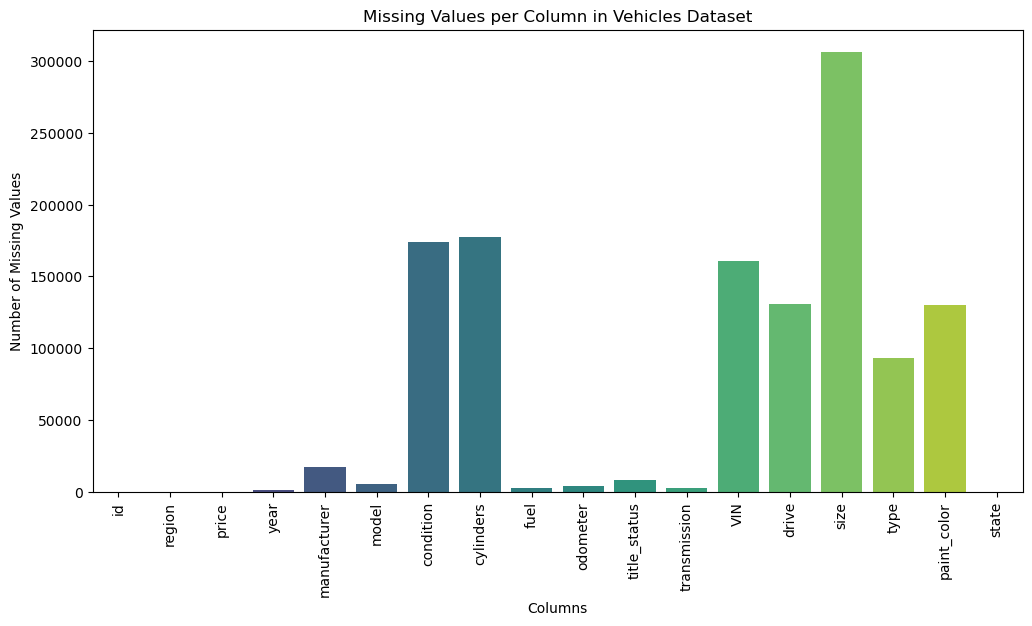

In [88]:
#Plot this data against a bar chart to represent the missing data visually
plt.figure(figsize=(12,6))
sns.barplot(
    x=missing_counts.index,
    y=missing_counts.values,
    hue=missing_counts.index,   
    palette="viridis",
    legend=False               
)

# Add labels and title
plt.xticks(rotation=90)
plt.ylabel("Number of Missing Values")
plt.xlabel("Columns")
plt.title("Missing Values per Column in Vehicles Dataset")
plt.show()

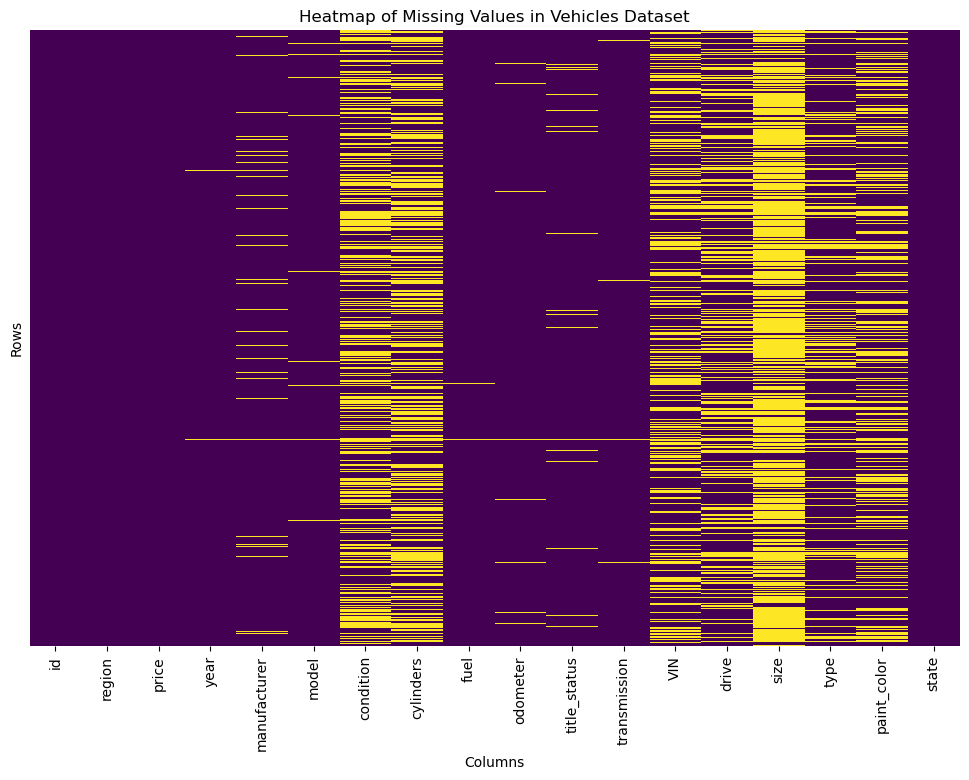

In [5]:
#Check missing values per row to understand if there are any incomplete records
# Create a boolean mask of missing values (True = missing)
missing_mask = auto.isnull()

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(missing_mask, 
            cbar=False,       # no color bar
            yticklabels=False, # hide row labels for readability
            cmap="viridis")   # color scheme

plt.title("Heatmap of Missing Values in Vehicles Dataset")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

In [6]:
# Count duplicate rows
duplicates = auto.duplicated().sum()
print("Number of duplicate rows:", duplicates)

Number of duplicate rows: 0


In [7]:
#Let us inspect if there are any typos in the manufacturer column that might potentially 
#change our analysis.
# Let us begin by getting unique manufacturer names
manufacturers = auto['manufacturer'].dropna().unique()
print("manufacturer:", manufacturers)

#Since the list is clean and doesn't contain any typos, we should not need to clean this data
#or perform any more actions on this.

manufacturer: ['gmc' 'chevrolet' 'toyota' 'ford' 'jeep' 'nissan' 'ram' 'mazda'
 'cadillac' 'honda' 'dodge' 'lexus' 'jaguar' 'buick' 'chrysler' 'volvo'
 'audi' 'infiniti' 'lincoln' 'alfa-romeo' 'subaru' 'acura' 'hyundai'
 'mercedes-benz' 'bmw' 'mitsubishi' 'volkswagen' 'porsche' 'kia' 'rover'
 'ferrari' 'mini' 'pontiac' 'fiat' 'tesla' 'saturn' 'mercury'
 'harley-davidson' 'datsun' 'aston-martin' 'land rover' 'morgan']


In [8]:
#Let's check for unique values in these fields

# Select categorical columns (object or category dtype)
categorical_cols = auto.select_dtypes(include=['object', 'category']).columns

# Loop through each categorical column and print unique values + counts
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(f"Number of unique values: {auto[col].nunique()}")
    print(f"Unique values: {auto[col].unique()[:20]}")  # show first 20 unique values for readability


Column: region
Number of unique values: 404
Unique values: ['prescott' 'fayetteville' 'florida keys' 'worcester / central MA'
 'greensboro' 'hudson valley' 'medford-ashland' 'erie' 'el paso'
 'bellingham' 'skagit / island / SJI' 'la crosse' 'auburn' 'birmingham'
 'dothan' 'florence / muscle shoals' 'gadsden-anniston'
 'huntsville / decatur' 'mobile' 'montgomery']

Column: manufacturer
Number of unique values: 42
Unique values: [nan 'gmc' 'chevrolet' 'toyota' 'ford' 'jeep' 'nissan' 'ram' 'mazda'
 'cadillac' 'honda' 'dodge' 'lexus' 'jaguar' 'buick' 'chrysler' 'volvo'
 'audi' 'infiniti' 'lincoln']

Column: model
Number of unique values: 29649
Unique values: [nan 'sierra 1500 crew cab slt' 'silverado 1500' 'silverado 1500 crew'
 'tundra double cab sr' 'f-150 xlt' 'sierra 2500 hd extended cab'
 'silverado 1500 double' 'tacoma' 'colorado extended cab'
 'corvette grand sport' 'cherokee' 'wrangler unlimited sport'
 'silverado 1500 regular' 'colorado crew cab z71'
 'tacoma access cab pickup' '

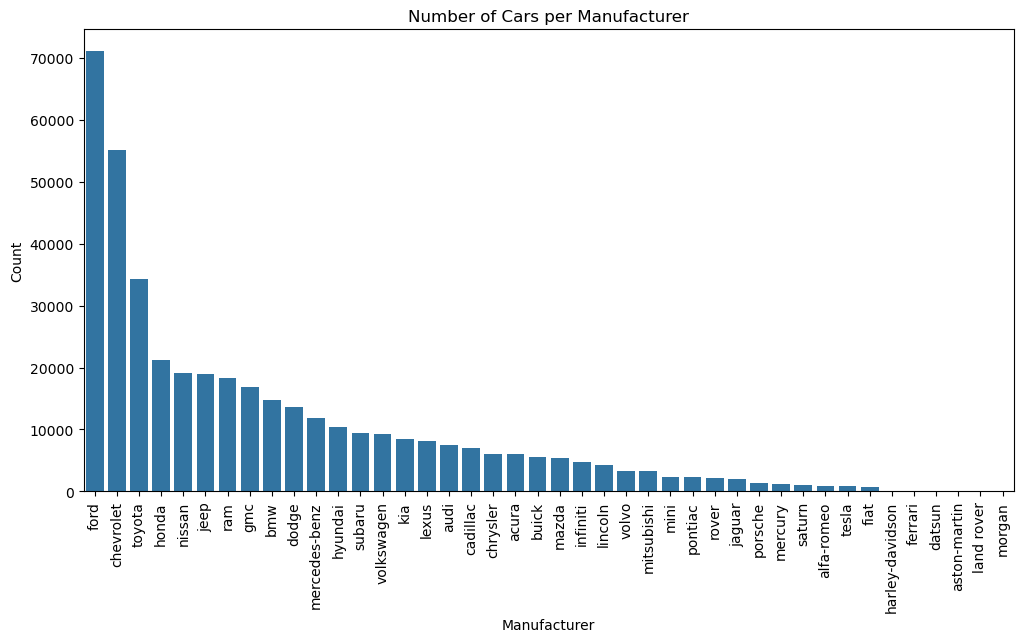

In [9]:
#Let's plot some of this data against a bar plot.
# Bar plot for manufacturer counts
plt.figure(figsize=(12,6))
sns.countplot(x='manufacturer', data=auto, order=auto['manufacturer'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Number of Cars per Manufacturer")
plt.xlabel("Manufacturer")
plt.ylabel("Count")
plt.show()

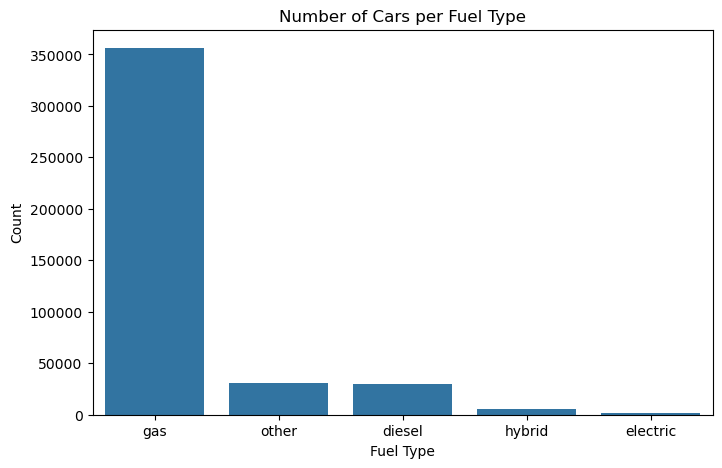

In [10]:
#Bar plot for fuel type counts
plt.figure(figsize=(8,5))
sns.countplot(x='fuel', data=auto, order=auto['fuel'].value_counts().index)
plt.title("Number of Cars per Fuel Type")
plt.xlabel("Fuel Type")
plt.ylabel("Count")
plt.show()

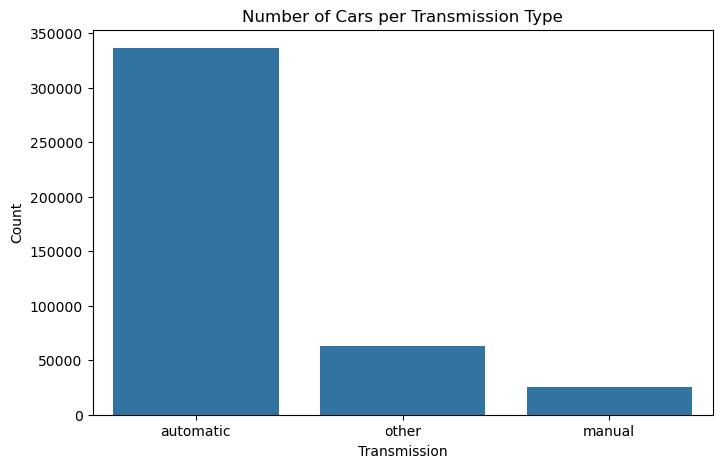

In [11]:
#Bar plot for transmission type counts
plt.figure(figsize=(8,5))
sns.countplot(x='transmission', data=auto, order=auto['transmission'].value_counts().index)
plt.title("Number of Cars per Transmission Type")
plt.xlabel("Transmission")
plt.ylabel("Count")
plt.show()

Correlation Matrix:
                id     price      year  odometer
id        1.000000 -0.002779 -0.059040  0.010721
price    -0.002779  1.000000 -0.004925  0.010032
year     -0.059040 -0.004925  1.000000 -0.157215
odometer  0.010721  0.010032 -0.157215  1.000000


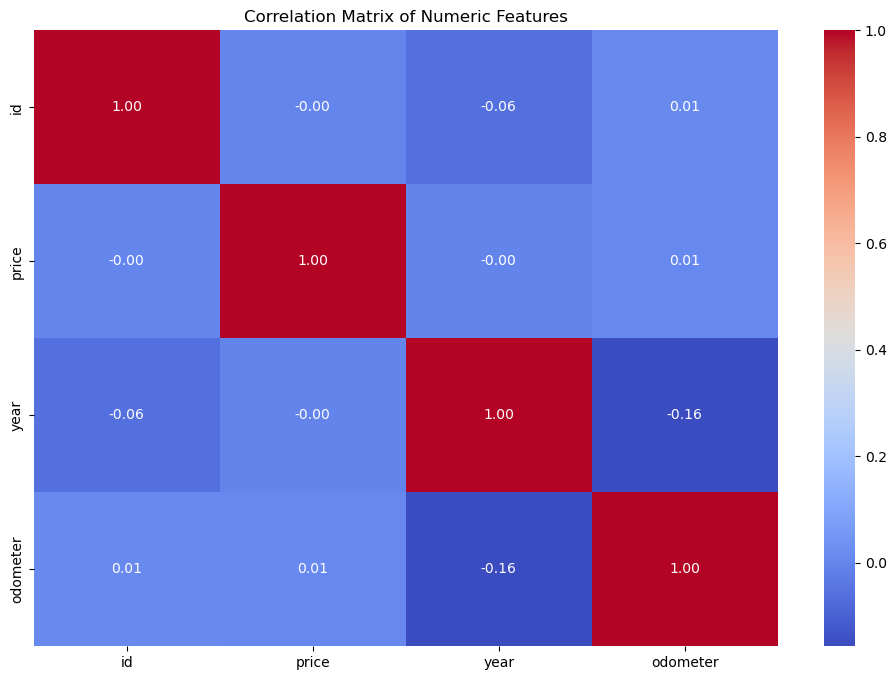

Top correlations with price:
odometer    0.010032
year        0.004925
id          0.002779
Name: price, dtype: float64

Correlations with direction:
odometer    0.010032
year       -0.004925
id         -0.002779
Name: price, dtype: float64


In [12]:
#Now, let's compute the correlation matrix for the numeric variables

# Drop the 'id' column
#auto = auto.drop(columns=['id'])

corr_matrix = auto.corr(numeric_only=True)

# Display correlation matrix
print("Correlation Matrix:")
print(corr_matrix)

# Plot heatmap for better visualization
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# Extract correlations with 'price'
price_corr = corr_matrix['price'].drop('price')  # drop self-correlation

# Sort correlations by absolute value (strongest relationships first)
top_corr = price_corr.abs().sort_values(ascending=False)

# Display top correlations
print("Top correlations with price:")
print(top_corr.head(10))

# If you want both direction and strength:
print("\nCorrelations with direction:")
print(price_corr.loc[top_corr.index].head(10))

manufacturer
mercedes-benz    531710.557333
volvo            383755.147896
toyota           234294.682621
jeep             150717.819659
chevrolet        115676.101645
ferrari          107438.736842
aston-martin      53494.541667
tesla             38354.456221
buick             36784.954736
ford              36411.718025
Name: price, dtype: float64


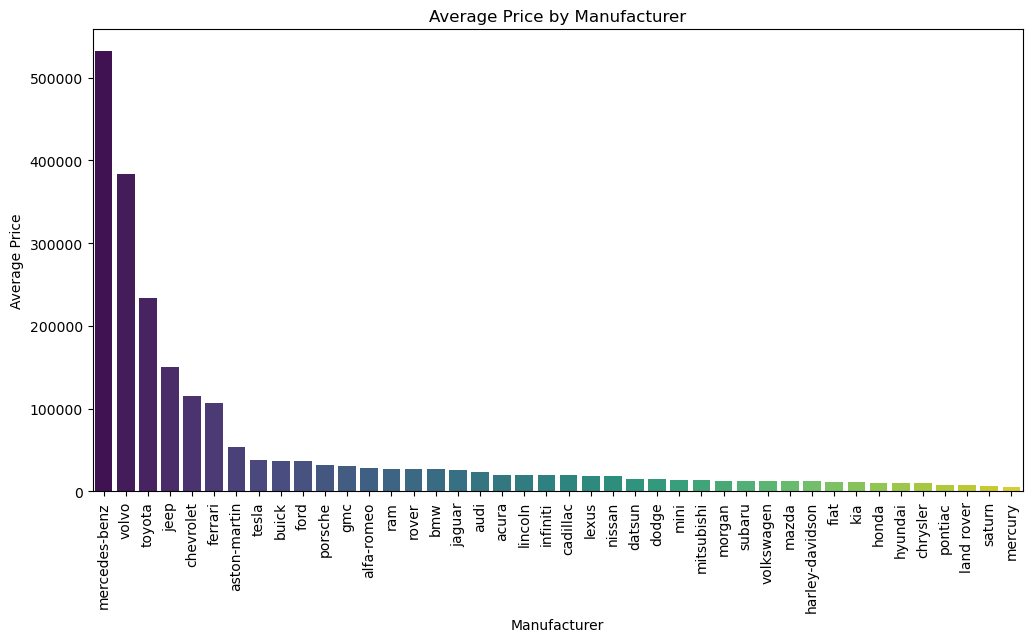

In [13]:
#Based on the correlation matrix, it does not seem like there is any linear relationship
# between car price and year or car price and odometer. There is a weak relationship
# between year and odometer. This makes sense since newer cars would tend to have lower
# mileage than older ones. Based on this, these are the following possibilities:
# 1. There might be outliers (e.g. high-end cars are priced very high irrespective of age/mileage
# 2. There might be other features that explain price better.

#Let's explore the impacts of the other features on price

# Average price by manufacturer
avg_price_by_brand = auto.groupby('manufacturer')['price'].mean().sort_values(ascending=False)
print(avg_price_by_brand.head(10))  # top 10 brands by average price

plt.figure(figsize=(12,6))
sns.barplot(x=avg_price_by_brand.index, y=avg_price_by_brand.values, hue=avg_price_by_brand.index, palette="viridis")
plt.xticks(rotation=90)
plt.title("Average Price by Manufacturer")
plt.ylabel("Average Price")
plt.xlabel("Manufacturer")
plt.show()

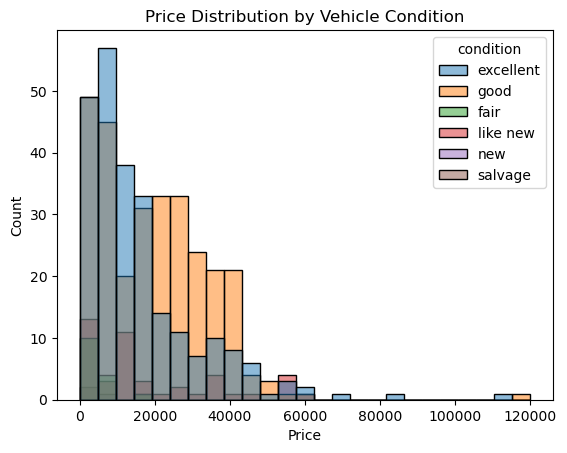

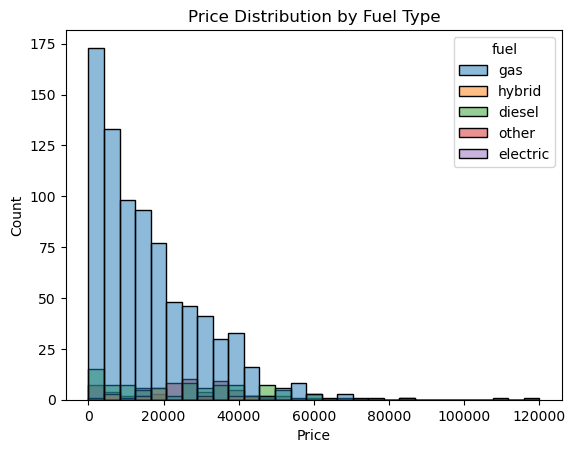

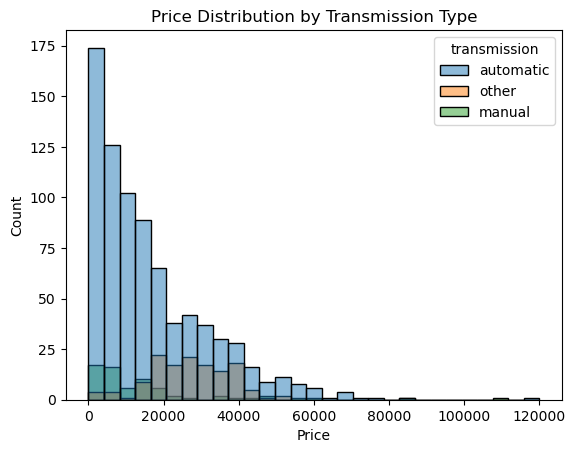

In [14]:
# Histogram of Price by Condition
sample_df = auto.sample(1000) 
sns.histplot(data=sample_df, x='price', hue='condition')
plt.title("Price Distribution by Vehicle Condition")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

# Histogram of Price by Fuel Type
sns.histplot(data=sample_df, x='price', hue='fuel')
plt.title("Price Distribution by Fuel Type")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

# Histogram of Price by Transmission Type
sns.histplot(data=sample_df, x='price', hue='transmission')
plt.title("Price Distribution by Transmission Type")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [15]:
# Remove rows with price == 0
print(f"Original dataset size: {auto.shape}")
auto = auto[auto['price'] > 0]
print(f"Dataset size after removing price=0 rows: {auto.shape}")

# Remove extreme prices and adjust thresholds
auto = auto[(auto['price'] >= 100) & (auto['price'] <= 150000)]
print(f"Dataset size after removing extreme prices: {auto.shape}")

# Find percentage of missing values
missing_percent = auto.isna().mean().round(4)*100  
missing_percent

Original dataset size: (426880, 18)
Dataset size after removing price=0 rows: (393985, 18)
Dataset size after removing extreme prices: (390462, 18)


id               0.00
region           0.00
price            0.00
year             0.30
manufacturer     4.04
model            1.17
condition       38.29
cylinders       40.60
fuel             0.66
odometer         0.58
title_status     1.98
transmission     0.47
VIN             38.55
drive           30.46
size            72.07
type            21.58
paint_color     29.62
state            0.00
dtype: float64

In [16]:
# Handle missing values

# Drop rows with missing values
auto_drop = auto.dropna()

# Drop columns with too many missing values (e.g., >40%)
auto_drop_cols = auto_drop.dropna(thresh=len(auto)*0.4, axis=1)

# Fill numeric columns with median
auto_fill_num = auto_drop.copy()
for col in auto_fill_num.select_dtypes(include=['float64','int64']).columns:
    auto_fill_num[col] = auto_fill_num[col].fillna(auto_fill_num[col].median())

# Fill categorical columns with mode
auto_fill_cat = auto_drop.copy()
for col in auto_fill_cat.select_dtypes(include=['object']).columns:
    auto_fill_cat[col] = auto_fill_cat[col].fillna(auto_fill_cat[col].mode()[0])

# Verify no missing values remain
print(auto_fill_cat.isnull().sum().sum(), "missing values left")
auto_drop

0 missing values left


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al
268,7315946365,birmingham,9000,2008.0,mazda,miata mx-5,excellent,4 cylinders,gas,56700.0,clean,automatic,JM1NC25F570128735,rwd,compact,convertible,white,al
337,7315354216,birmingham,8950,2011.0,ford,f-150,excellent,6 cylinders,gas,164000.0,clean,automatic,1FTMF1CM6BKD55331,fwd,full-size,truck,white,al
338,7315349921,birmingham,4000,1972.0,mercedes-benz,benz,fair,6 cylinders,gas,88100.0,clean,automatic,1.14023E+13,rwd,full-size,coupe,silver,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426785,7303314912,wyoming,23495,2015.0,ford,f150 xlt 4x4,like new,8 cylinders,gas,146795.0,clean,automatic,1FTFX1EF5FFC24427,4wd,full-size,truck,black,wy
426788,7303227528,wyoming,12995,2016.0,chevrolet,cruze lt,like new,4 cylinders,gas,61127.0,clean,automatic,1G1BE5SM0G7266569,fwd,compact,sedan,silver,wy
426792,7303114896,wyoming,32999,2014.0,ford,"f350, xlt",excellent,8 cylinders,diesel,154642.0,clean,automatic,1FT8W3DT3EEB41548,4wd,full-size,pickup,brown,wy
426793,7303112347,wyoming,15999,2018.0,chevrolet,"cruze, lt",excellent,4 cylinders,gas,36465.0,clean,automatic,1G1BE5SM7J7133704,fwd,mid-size,sedan,black,wy


In [111]:
# Identify categorical and numeric columns
#categorical_cols = X.select_dtypes(include=['object', 'category']).columns
#numeric_cols = X.select_dtypes(include=['int64','float64']).columns

#print("Categorical columns:", categorical_cols)
#print("Numeric columns:", numeric_cols)

In [17]:
# Feature Engineering - Calculate the age of the cars
current_year = 2025  
auto_drop['age'] = current_year - auto_drop['year']
auto_drop.drop('year', axis=1, inplace=True)
auto_drop

C:\Users\manisha\AppData\Local\Temp\ipykernel_6020\4124241520.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auto_drop['age'] = current_year - auto_drop['year']
C:\Users\manisha\AppData\Local\Temp\ipykernel_6020\4124241520.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auto_drop.drop('year', axis=1, inplace=True)


,id,region,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state,age
215,7316482063,birmingham,4000,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al,23.0
219,7316429417,birmingham,2500,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al,30.0
268,7315946365,birmingham,9000,mazda,miata mx-5,excellent,4 cylinders,gas,56700.0,clean,automatic,JM1NC25F570128735,rwd,compact,convertible,white,al,17.0
337,7315354216,birmingham,8950,ford,f-150,excellent,6 cylinders,gas,164000.0,clean,automatic,1FTMF1CM6BKD55331,fwd,full-size,truck,white,al,14.0
338,7315349921,birmingham,4000,mercedes-benz,benz,fair,6 cylinders,gas,88100.0,clean,automatic,1.14023E+13,rwd,full-size,coupe,silver,al,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426785,7303314912,wyoming,23495,ford,f150 xlt 4x4,like new,8 cylinders,gas,146795.0,clean,automatic,1FTFX1EF5FFC24427,4wd,full-size,truck,black,wy,10.0
426788,7303227528,wyoming,12995,chevrolet,cruze lt,like new,4 cylinders,gas,61127.0,clean,automatic,1G1BE5SM0G7266569,fwd,compact,sedan,silver,wy,9.0
426792,7303114896,wyoming,32999,ford,"f350, xlt",excellent,8 cylinders,diesel,154642.0,clean,automatic,1FT8W3DT3EEB41548,4wd,full-size,pickup,brown,wy,11.0
426793,7303112347,wyoming,15999,chevrolet,"cruze, lt",excellent,4 cylinders,gas,36465.0,clean,automatic,1G1BE5SM7J7133704,fwd,mid-size,sedan,black,wy,7.0


In [18]:
# Handle Outliers
numerical_features = ['price', 'odometer']

for col in numerical_features:
    Q1 = auto_drop[col].quantile(0.25)
    Q3 = auto_drop[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    auto_drop[col] = np.clip(auto_drop[col], lower_bound, upper_bound)
    
    print(f"Outliers in '{col}' capped. Lower bound: {lower_bound}, Upper bound: {upper_bound}")

Outliers in 'price' capped. Lower bound: -15925.0, Upper bound: 47795.0
Outliers in 'odometer' capped. Lower bound: -42023.5, Upper bound: 255372.5


C:\Users\manisha\AppData\Local\Temp\ipykernel_6020\2757681608.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auto_drop[col] = np.clip(auto_drop[col], lower_bound, upper_bound)
C:\Users\manisha\AppData\Local\Temp\ipykernel_6020\2757681608.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auto_drop[col] = np.clip(auto_drop[col], lower_bound, upper_bound)


In [19]:
auto_drop.sample(10)

,id,region,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state,age
196521,7316305629,detroit metro,13000,honda,accord,excellent,4 cylinders,gas,62000.0,rebuilt,automatic,1HGCR2F32GA146504,fwd,mid-size,sedan,grey,mi,9.0
351893,7313385393,chattanooga,38000,mercedes-benz,gls 450 4matic,excellent,6 cylinders,gas,70388.0,clean,automatic,4JGDF6EE5HA860260,4wd,full-size,SUV,white,tn,8.0
387058,7314720693,vermont,15800,subaru,forester premium awd,like new,4 cylinders,gas,70678.0,clean,automatic,JF2SJADC1GH448485,4wd,mid-size,wagon,silver,vt,9.0
76358,7316330661,denver,7000,ford,f150 4x4,good,8 cylinders,gas,215500.0,clean,automatic,1FTRW08LX1KF22306,4wd,full-size,pickup,silver,co,24.0
64099,7315317143,stockton,15977,honda,civic lx,excellent,4 cylinders,gas,57555.0,clean,automatic,19XFC5F52GE225568,fwd,compact,sedan,grey,ca,9.0
103087,7309391241,ocala,29700,chevrolet,silverado 1500 lt,excellent,6 cylinders,gas,65550.0,clean,automatic,1GCVKREH5EZ120415,4wd,full-size,pickup,silver,fl,11.0
233832,7310468376,charlotte,33877,ram,promaster 1500,excellent,6 cylinders,gas,30902.0,clean,automatic,3C6TRVBG8JE143479,fwd,full-size,van,white,nc,7.0
388783,7304356847,vermont,16795,toyota,rav4,good,4 cylinders,gas,117674.0,clean,automatic,2T3DFREV2FW346175,4wd,full-size,SUV,white,vt,10.0
162087,7311432962,omaha / council bluffs,20990,ram,2500,good,8 cylinders,gas,121850.0,clean,automatic,3D7LT2ET8AG132512,4wd,full-size,truck,black,ia,15.0
174027,7302688979,louisville,7975,volkswagen,routan,excellent,6 cylinders,gas,109427.0,clean,automatic,2V4RW3D13AR209403,fwd,full-size,van,white,ky,15.0


In [74]:
#Perform the test-train split
# Split data

#X = auto.drop('price', axis=1)
#y = auto['price']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [27]:
#Linear Regression

# Separate features and target
X = auto_drop.drop(columns=['price'])
y = auto_drop['price']

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numeric_cols = X.select_dtypes(include=['int64','float64']).columns

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

# Define preprocessing for categorical data: One-Hot Encoding
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing for categorical and numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ])

# Example pipeline: preprocessing + model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model.fit(X_train, y_train)

# Evaluate
print("Model R^2 on test set:", model.score(X_test, y_test))

Categorical columns: Index(['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'title_status', 'transmission', 'VIN', 'drive', 'size', 'type',
       'paint_color', 'state'],
      dtype='object')
Numeric columns: Index(['id', 'odometer', 'age'], dtype='object')
Model R^2 on test set: 0.21920051724131462


In [28]:
# Separate features and target
X = auto_drop.drop('price', axis=1)
y = auto_drop['price']

# Preparing test and development datasets by splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define features
numerical_features = ['odometer', 'age']
onehot_features = ['fuel', 'transmission', 'drive', 'type', 'paint_color', 'title_status']
target_features = ['manufacturer', 'model', 'state']


# Preprocessor Definition
preprocessor = ColumnTransformer(
    transformers=[
        ('num_pipe', Pipeline(steps=[
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
            ('scaler', StandardScaler())
        ]), numerical_features),

        ('target_enc', ce.TargetEncoder(), target_features),

        ('onehot_enc', OneHotEncoder(handle_unknown='ignore', drop='first'), onehot_features)
    ],
    remainder='drop'
)

# Pipeline for Ridge
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

ridge_params = {
    'model__alpha': [0.01, 0.1, 1, 10, 100]
}

ridge_grid = GridSearchCV(
    ridge_pipeline,
    param_grid=ridge_params,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
print("Running GridSearchCV for Ridge...")
ridge_grid.fit(X_train, y_train)

Running GridSearchCV for Ridge...


,estimator,"Pipeline(step...l', Ridge())])"
,param_grid,"{'model__alpha': [0.01, 0.1, ...]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num_pipe', ...), ('target_enc', ...), ...]"


In [29]:
# Separate features and target
X = auto_drop.drop('price', axis=1)
y = auto_drop['price']

# Preparing test and development datasets by splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define features
numerical_features = ['odometer', 'age']
onehot_features = ['fuel', 'transmission', 'drive', 'type', 'paint_color', 'title_status']
target_features = ['manufacturer', 'model', 'state']


# Preprocessor Definition
preprocessor = ColumnTransformer(
    transformers=[
        ('num_pipe', Pipeline(steps=[
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
            ('scaler', StandardScaler())
        ]), numerical_features),

        ('target_enc', ce.TargetEncoder(), target_features),

        ('onehot_enc', OneHotEncoder(handle_unknown='ignore', drop='first'), onehot_features)
    ],
    remainder='drop'
)

# Pipeline for Lasso
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Lasso(max_iter=10000, random_state=42))
])

lasso_params = {
    'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1]
}

lasso_grid = GridSearchCV(
    lasso_pipeline,
    param_grid=lasso_params,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
print("Running GridSearchCV for Lasso...")
lasso_grid.fit(X_train, y_train)

Running GridSearchCV for Lasso...


C:\Users\manisha\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.757e+09, tolerance: 3.530e+08
  model = cd_fast.sparse_enet_coordinate_descent(


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__alpha': [0.0001, 0.001, ...]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num_pipe', ...), ('target_enc', ...), ...]"


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [33]:
#Now that we have finished modelling, let's evaluate the results.
print("Evaluations:")

#Ridge Model
# Get the best estimators
best_ridge = ridge_grid.best_estimator_

#Make predictions using the Ridge model
ridge_preds = best_ridge.predict(X_test)

#Calculate MAE for the Ridge model
ridge_mae = mean_absolute_error(y_test, ridge_preds)

#Calculate the R^2 score
ridge_r2 = r2_score(y_test, ridge_preds)

print("Ridge Model:")
print(f"Best alpha = {ridge_grid.best_params_['model__alpha']}")
print(f"Ridge Test MAE: ${ridge_mae:,.2f}")
print(f"Ridge Test R*R: {ridge_r2:.2f}")

#Lasso Model
# Get the best estimators
best_lasso = lasso_grid.best_estimator_

#Make predictions using the Lasso model
lasso_preds = best_lasso.predict(X_test)

#Calculate MAE for the Lasso model
lasso_mae = mean_absolute_error(y_test, lasso_preds)

#Calculate the R^2 score
lasso_r2 = r2_score(y_test, lasso_preds)

print("\nLasso Model:")
print(f"Lasso: Best alpha = {lasso_grid.best_params_['model__alpha']}")
print(f"Lasso Test MAE: ${lasso_mae:,.2f}")
print(f"Lasso Test R*R: {lasso_r2:.2f}")

Evaluations:
Ridge Model:
Best alpha = 0.01
Ridge Test MAE: $5,293.14
Ridge Test R*R: 0.64

Lasso Model:
Lasso: Best alpha = 0.0001
Lasso Test MAE: $4,211.06
Lasso Test R*R: 0.76


Bar chart comparing Ridge and Lasso MAE values


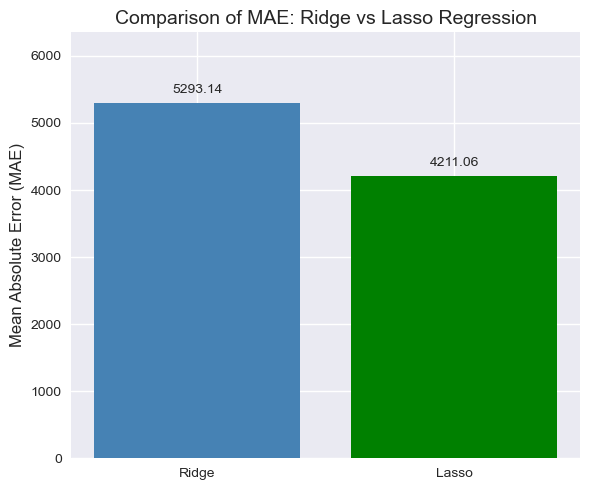

In [42]:
# Creating bar chart comparing Ridge vs Lasso MAE values

# Model names and corresponding MAE values
models = ['Ridge', 'Lasso']
mae_values = [ridge_mae, lasso_mae]

# Create bar chart
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(6, 5))
bars = ax.bar(models, mae_values, color=['steelblue', 'green'])

# Add value annotations on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10)

# Labeling
ax.set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
ax.set_title('Comparison of MAE: Ridge vs Lasso Regression', fontsize=14)
ax.set_ylim(0, max(mae_values) * 1.2)

# Save the plot
#output_path = "/images/ridge_vs_lasso_mae.png"
plt.tight_layout()
#plt.savefig(output_path)

print("Bar chart comparing Ridge and Lasso MAE values")

Bar chart comparing R² scores of Ridge and Lasso models


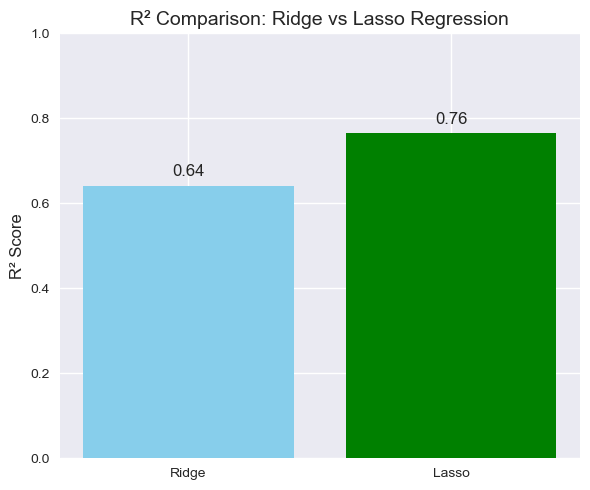

In [43]:
# Creating bar chart comparing Ridge vs Lasso R^2 values

# Data for plotting
models = ['Ridge', 'Lasso']
r2_scores = [ridge_r2, lasso_r2]
colors = ['skyblue', 'green']

# Create bar chart
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(6, 5))
bars = ax.bar(models, r2_scores, color=colors)

# Add value annotations
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12)

# Label axes and title
ax.set_ylabel('R² Score', fontsize=12)
ax.set_title('R² Comparison: Ridge vs Lasso Regression', fontsize=14)
ax.set_ylim(0, 1)

# Save plot
#output_path = 'images/ridge_lasso_r2_comparison.png'
plt.tight_layout()
#plt.savefig(output_path)

print("Bar chart comparing R² scores of Ridge and Lasso models")

In [44]:
#Based on these observations, we can see that the Lasso model performs better.
print("We can see that the Lasso model performed better on our test data.")

We can see that the Lasso model performed better on our test data.


In [45]:
#Let's get the coefficients.
preprocessor = lasso_grid.best_estimator_.named_steps['preprocessor']

#Get the feature names
feature_names = preprocessor.get_feature_names_out()

# Get the Lasso model from the pipeline
lasso_model = lasso_grid.best_estimator_.named_steps['model']

# Create the Series with the correct number of coefficients and feature names
coefficients = pd.Series(lasso_model.coef_, index=feature_names)

# Display the non-zero coefficients
important_features = coefficients[coefficients != 0].sort_values(ascending=False)
print("Important Features (ranked by coefficient magnitude):\n")
print(important_features)

Important Features (ranked by coefficient magnitude):

num_pipe__age^2                         6043.227297
onehot_enc__type_offroad                4001.954604
onehot_enc__type_convertible            3923.315750
onehot_enc__type_truck                  3771.645978
onehot_enc__type_pickup                 3064.817029
onehot_enc__type_coupe                  2423.588895
num_pipe__odometer^2                    2310.879913
onehot_enc__type_bus                    2269.674499
onehot_enc__type_other                  2181.959721
onehot_enc__type_mini-van               1711.792178
onehot_enc__transmission_manual         1298.265160
onehot_enc__type_van                     873.744264
num_pipe__odometer age                   696.166470
onehot_enc__transmission_other           490.403835
onehot_enc__title_status_lien            254.086739
onehot_enc__paint_color_orange           212.120798
target_enc__model                          0.563449
target_enc__state                          0.208231
target_en

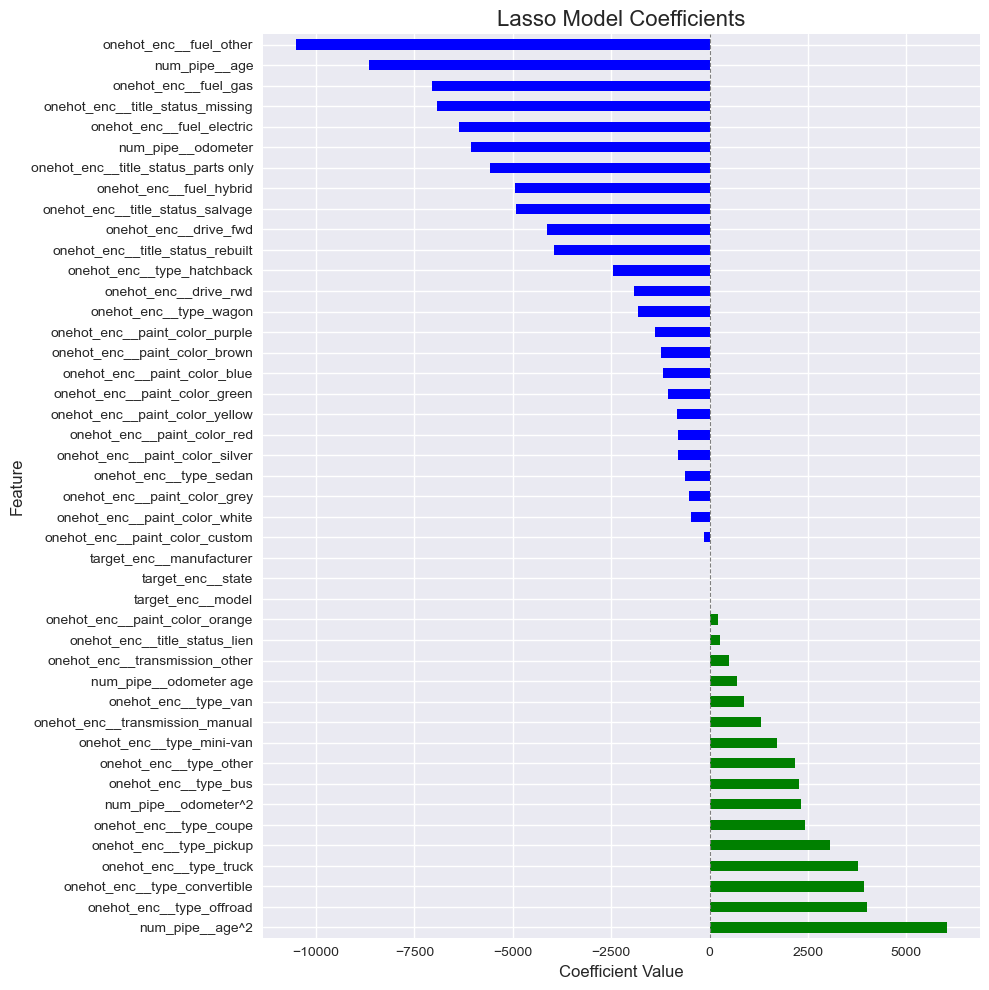

In [46]:
# Plotting the coefficients
plt.figure(figsize=(10, 10))
important_features.plot(kind='barh', color=['green' if x > 0 else 'blue' for x in important_features])
plt.title('Lasso Model Coefficients', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.axvline(x=0, color='grey', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.savefig('images/vehicles_price_affecting_features.png', dpi=300)
plt.show()

In [47]:
print("Lasso Regression outperforms Ridge on both accuracy (lower MAE) and explanatory power (higher R²).")
print("\nLasso’s feature selection capability highlights which attributes most strongly drive car prices, making it more interpretable and useful for insights.")

Lasso Regression outperforms Ridge on both accuracy (lower MAE) and explanatory power (higher R²).

Lasso’s feature selection capability highlights which attributes most strongly drive car prices, making it more interpretable and useful for insights.


In [49]:
#Top Positive Drivers of Price:

#Vehicle age² (older cars with certain nonlinear effects).

#Vehicle types like offroad, convertible, truck, pickup, coupe.

#Odometer² (mileage effects).

#Top Negative Drivers of Price:

#Title issues (salvage, rebuilt, lien, missing, parts only).

#Fuel types (gas, electric, hybrid, other) → lower resale values.

#Certain paint colors (purple, brown, blue, green, silver, etc.).

#Drive types (FWD, RWD) and body styles like sedan/hatchback.


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

In [ ]:
Here are the basic  findings:

Key Drivers of Price ()

Positive Influences (increase resale value)
Vehicle Age² → Older vehicles with certain nonlinear effects can command higher prices in niche markets.

Body Types: Offroad, convertible, truck, pickup, coupe.

Mileage² (odometer²): Certain mileage patterns can positively influence perceived value.

Negative Influences (decrease resale value)
Title Issues: Salvage, rebuilt, lien, missing, or “parts only” titles sharply reduce resale value.

Fuel Types: Gas, electric, hybrid, and “other” categories showed lower resale values compared to baseline.

Paint Colors: Purple, brown, blue, green, silver, and red tend to reduce resale value.

Drive Types: FWD and RWD vehicles are less valuable compared to AWD.

Body Styles: Sedans and hatchbacks underperform compared to trucks, SUVs, and specialty vehicles.

4. Recommendations for Dealers
Inventory Acquisition:

Prioritize trucks, pickups, convertibles, and offroad vehicles.

Avoid vehicles with title issues or less desirable paint colors.

Pricing Strategy:

Adjust pricing downward for vehicles with negative attributes (e.g., salvage titles, unpopular colors).

Highlight positive attributes in marketing (e.g., specialty body types).

Marketing Focus:

Promote vehicles with high-demand body styles and emphasize clean titles.

Consider offering incentives for less desirable inventory (e.g., sedans with salvage titles).